In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp /content/drive/MyDrive/clips.zip .

In [3]:
! cp /content/drive/MyDrive/text_video_path.csv .

In [4]:
! unzip clips.zip

Archive:  clips.zip
   creating: clips/
  inflating: clips/-MHnvg7xZsI_0_20.mp4  
  inflating: clips/-MHnvg7xZsI_100_120.mp4  
  inflating: clips/-MHnvg7xZsI_120_140.mp4  
  inflating: clips/-MHnvg7xZsI_140_160.mp4  
  inflating: clips/-MHnvg7xZsI_160_180.mp4  
  inflating: clips/-MHnvg7xZsI_180_200.mp4  
  inflating: clips/-MHnvg7xZsI_200_220.mp4  
  inflating: clips/-MHnvg7xZsI_20_40.mp4  
  inflating: clips/-MHnvg7xZsI_220_227.mp4  
  inflating: clips/-MHnvg7xZsI_40_60.mp4  
  inflating: clips/-MHnvg7xZsI_60_80.mp4  
  inflating: clips/-MHnvg7xZsI_80_100.mp4  
  inflating: clips/1pH1F6s5EQI_0_20.mp4  
  inflating: clips/1pH1F6s5EQI_100_120.mp4  
  inflating: clips/1pH1F6s5EQI_120_140.mp4  
  inflating: clips/1pH1F6s5EQI_140_160.mp4  
  inflating: clips/1pH1F6s5EQI_160_180.mp4  
  inflating: clips/1pH1F6s5EQI_180_200.mp4  
  inflating: clips/1pH1F6s5EQI_200_220.mp4  
  inflating: clips/1pH1F6s5EQI_20_40.mp4  
  inflating: clips/1pH1F6s5EQI_220_240.mp4  
  inflating: clips/1pH1F6s5EQI

In [5]:
!pip install diffusers transformers accelerate opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [6]:
# Text-to-Video Generation Pipeline for Google Colab
# Optimized for limited resources with custom dataset training

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, DDPMScheduler
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [7]:

# ========================= CONFIGURATION =========================
class Config:
    # Model parameters
    TEXT_ENCODER_MODEL = "openai/clip-vit-base-patch32"
    VIDEO_SIZE = (64, 64)  # Small size for Colab
    INFERENCE_SIZE = (256, 256)
    FRAME_COUNT = 100  # Short videos for memory efficiency
    BATCH_SIZE = 2  # Small batch size for limited GPU memory
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50

    # Training parameters
    GRADIENT_ACCUMULATION_STEPS = 4
    MIXED_PRECISION = True
    CHECKPOINT_EVERY = 10

    # Data paths
    CSV_PATH = "/content/text_video_path.csv"  # Your CSV file path
    OUTPUT_DIR = "/content/drive/MyDrive/text_to_video_latest"
    MODEL_SAVE_PATH = "/content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth"

        # Audio parameters
    AUDIO_SAMPLE_RATE = 22050
    AUDIO_DURATION = 20.0  # seconds


In [8]:

# ========================= DATASET CLASS =========================
class TextVideoDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path, encoding='cp1252')
        self.transform = transform

        # Video preprocessing transform
        self.video_transform = transforms.Compose([
            transforms.Resize(Config.VIDEO_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def load_video(self, video_path):
        """Load video frames and resize to target resolution"""
        cap = cv2.VideoCapture(video_path)
        frames = []

        # Read frames
        while len(frames) < Config.FRAME_COUNT:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)

            # Apply transforms
            frame = self.video_transform(frame)
            frames.append(frame)

        cap.release()

        # Pad with last frame if video is shorter
        while len(frames) < Config.FRAME_COUNT:
            frames.append(frames[-1] if frames else torch.zeros(3, *Config.VIDEO_SIZE))

        # Stack frames: [frames, channels, height, width]
        return torch.stack(frames[:Config.FRAME_COUNT])

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['text']
        video_path = row['video_path']

        # Load video
        try:
            video = self.load_video(video_path)
        except Exception as e:
            print(f"Error loading video {video_path}: {e}")
            # Return dummy video
            video = torch.zeros(Config.FRAME_COUNT, 3, *Config.VIDEO_SIZE)

        return {
            'text': text,
            'video': video
        }

In [9]:
class TextToVideoModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Text encoder (frozen CLIP)
        self.tokenizer = CLIPTokenizer.from_pretrained(Config.TEXT_ENCODER_MODEL)
        self.text_encoder = CLIPTextModel.from_pretrained(Config.TEXT_ENCODER_MODEL)

        # Freeze text encoder
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Video decoder - simplified U-Net based architecture
        self.video_decoder = VideoDecoder()

        # Noise scheduler for diffusion
        self.noise_scheduler = DDPMScheduler(
            num_train_timesteps=1000,
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear"
        )

    def encode_text(self, text_list):
        """Encode text using CLIP"""
        inputs = self.tokenizer(
            text_list,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=77
        )

        # Move inputs to the same device as the model
        device = next(self.text_encoder.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            text_embeddings = self.text_encoder(**inputs).last_hidden_state

        return text_embeddings

    def forward(self, text_list, target_video=None):
        """Forward pass for training"""
        # Encode text
        text_embeddings = self.encode_text(text_list)

        if target_video is not None:
            # Training mode - add noise to target video
            # Reshape video from [batch, frames, channels, height, width] to [batch, channels, frames, height, width]
            target_video = target_video.permute(0, 2, 1, 3, 4)

            batch_size = target_video.shape[0]

            # Sample random timesteps
            timesteps = torch.randint(
                0, self.noise_scheduler.config.num_train_timesteps,
                (batch_size,), device=target_video.device
            )

            # Add noise to video
            noise = torch.randn_like(target_video)
            noisy_video = self.noise_scheduler.add_noise(target_video, noise, timesteps)

            # Predict noise
            predicted_noise = self.video_decoder(noisy_video, timesteps, text_embeddings)

            return predicted_noise, noise
        else:
            # Inference mode
            return self.generate_video(text_embeddings)

    def generate_video(self, text_embeddings):
        """Generate video from text embeddings"""
        batch_size = text_embeddings.shape[0]

        # Start with random noise - correct shape [batch, channels, frames, height, width]
        video = torch.randn(
            batch_size, 3, Config.FRAME_COUNT, *Config.VIDEO_SIZE,
            device=text_embeddings.device
        )

        # Denoising loop
        for t in tqdm(self.noise_scheduler.timesteps, desc="Generating video"):
            timestep = torch.full((batch_size,), t, device=video.device)

            with torch.no_grad():
                predicted_noise = self.video_decoder(video, timestep, text_embeddings)

            # Remove noise
            video = self.noise_scheduler.step(predicted_noise, t, video).prev_sample

        # Convert back to [batch, frames, channels, height, width] for output
        video = video.permute(0, 2, 1, 3, 4)
        return video


In [10]:

class VideoDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

        # Text projection
        self.text_projection = nn.Linear(512, 512)  # CLIP embedding size

        # Initial convolution
        self.input_conv = nn.Conv3d(3, 64, 3, padding=1)

        # Encoder path
        self.down1 = nn.Sequential(
            ResBlock3D(64, 128),
            nn.Conv3d(128, 128, 3, stride=2, padding=1)
        )

        self.down2 = nn.Sequential(
            ResBlock3D(128, 256),
            nn.Conv3d(256, 256, 3, stride=2, padding=1)
        )

        self.down3 = nn.Sequential(
            ResBlock3D(256, 512),
            nn.Conv3d(512, 512, 3, stride=2, padding=1)
        )

        # Bottleneck with text conditioning
        self.bottleneck = ResBlock3D(512 + 512, 512)  # +512 for text conditioning

        # Decoder path
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(512, 512, 3, stride=2, padding=1, output_padding=1),
            ResBlock3D(512 + 512, 256)  # +512 for skip connection
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(256, 256, 3, stride=2, padding=1, output_padding=1),
            ResBlock3D(256 + 256, 128)  # +256 for skip connection
        )

        self.up3 = nn.Sequential(
            nn.ConvTranspose3d(128, 128, 3, stride=2, padding=1, output_padding=1),
            ResBlock3D(128 + 128, 64)   # +128 for skip connection
        )

        # Output layer
        self.output_conv = nn.Conv3d(64, 3, 3, padding=1)

    def forward(self, video, timestep, text_embeddings):
        # Time embedding
        time_emb = self.get_time_embedding(timestep)
        time_emb = self.time_embedding(time_emb)

        # Text embedding (use mean pooling)
        text_emb = self.text_projection(text_embeddings.mean(dim=1))

        # Initial convolution
        x = self.input_conv(video)

        # Encoder path with skip connections
        skip1 = self.down1[0](x, time_emb)  # ResBlock before downsampling
        x = self.down1[1](skip1)            # Downsampling

        skip2 = self.down2[0](x, time_emb)  # ResBlock before downsampling
        x = self.down2[1](skip2)            # Downsampling

        skip3 = self.down3[0](x, time_emb)  # ResBlock before downsampling
        x = self.down3[1](skip3)            # Downsampling

        # Add text conditioning to bottleneck
        batch_size, channels, frames, height, width = x.shape
        text_emb_spatial = text_emb.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        text_emb_spatial = text_emb_spatial.expand(batch_size, -1, frames, height, width)
        x = torch.cat([x, text_emb_spatial], dim=1)

        # Bottleneck
        x = self.bottleneck(x, time_emb)

        # Decoder path with skip connections
        # Up1: 512 -> 256
        x = self.up1[0](x)  # Upsample
        x = self.match_spatial_dims(x, skip3)  # Match dimensions
        x = torch.cat([x, skip3], dim=1)       # Concatenate skip
        x = self.up1[1](x, time_emb)           # ResBlock

        # Up2: 256 -> 128
        x = self.up2[0](x)  # Upsample
        x = self.match_spatial_dims(x, skip2)  # Match dimensions
        x = torch.cat([x, skip2], dim=1)       # Concatenate skip
        x = self.up2[1](x, time_emb)           # ResBlock

        # Up3: 128 -> 64
        x = self.up3[0](x)  # Upsample
        x = self.match_spatial_dims(x, skip1)  # Match dimensions
        x = torch.cat([x, skip1], dim=1)       # Concatenate skip
        x = self.up3[1](x, time_emb)           # ResBlock

        # Output
        return self.output_conv(x)

    def match_spatial_dims(self, x, skip_conn):
        """Ensure spatial dimensions match before concatenation"""
        if x.shape[2:] != skip_conn.shape[2:]:
            x = nn.functional.interpolate(
                x,
                size=skip_conn.shape[2:],
                mode='trilinear',
                align_corners=False
            )
        return x

    def get_time_embedding(self, timestep):
        """Sinusoidal time embedding"""
        half_dim = 64
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=timestep.device) * -embeddings)
        embeddings = timestep[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


In [14]:
class ResBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(min(8, out_channels), out_channels)
        self.norm2 = nn.GroupNorm(min(8, out_channels), out_channels)
        self.time_mlp = nn.Linear(512, out_channels)

        self.skip_conv = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_emb):
        h = self.conv1(x)
        h = self.norm1(h)

        # Add time embedding with proper broadcasting
        time_emb = self.time_mlp(time_emb)
        # Reshape time embedding to match spatial dimensions
        batch_size, channels, frames, height, width = h.shape
        time_emb = time_emb.view(batch_size, channels, 1, 1, 1)
        time_emb = time_emb.expand(batch_size, channels, frames, height, width)
        h = h + time_emb

        h = nn.functional.relu(h)
        h = self.conv2(h)
        h = self.norm2(h)

        return nn.functional.relu(h + self.skip_conv(x))

In [15]:
# ========================= TRAINING FUNCTION =========================
def train_model():
    """Main training function"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create dataset and dataloader
    dataset = TextVideoDataset(Config.CSV_PATH)
    dataloader = DataLoader(
        dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # Set to 0 for Colab compatibility
        pin_memory=True if device.type == 'cuda' else False
    )

    # Initialize model
    model = TextToVideoModel().to(device)

    # Move noise scheduler to device
    model.noise_scheduler = model.noise_scheduler

    optimizer = optim.AdamW(model.video_decoder.parameters(), lr=Config.LEARNING_RATE)
    criterion = nn.MSELoss()

    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler() if Config.MIXED_PRECISION and device.type == 'cuda' else None

    # Training loop
    model.train()
    losses = []

    for epoch in range(Config.NUM_EPOCHS):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{Config.NUM_EPOCHS}")

        for batch_idx, batch in enumerate(progress_bar):
            text_list = batch['text']
            video = batch['video'].to(device)

            # Forward pass
            if Config.MIXED_PRECISION and device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    predicted_noise, target_noise = model(text_list, video)
                    loss = criterion(predicted_noise, target_noise)
                    loss = loss / Config.GRADIENT_ACCUMULATION_STEPS

                scaler.scale(loss).backward()

                if (batch_idx + 1) % Config.GRADIENT_ACCUMULATION_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                predicted_noise, target_noise = model(text_list, video)
                loss = criterion(predicted_noise, target_noise)
                loss = loss / Config.GRADIENT_ACCUMULATION_STEPS

                loss.backward()

                if (batch_idx + 1) % Config.GRADIENT_ACCUMULATION_STEPS == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % Config.CHECKPOINT_EVERY == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f"checkpoint_epoch_{epoch+1}.pth")

    # Save final model
        torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
        print(f"Model saved to {Config.MODEL_SAVE_PATH}")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('training_loss.png')
    plt.show()

In [16]:
import shutil
# ========================= INFERENCE FUNCTION =========================
def generate_video_from_text(text_prompt, model_path=None, high_res=True):
    """Generate video from text prompt with high resolution and audio"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = TextToVideoModel().to(device)

    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=device))

    model.eval()

    # Generate video
    with torch.no_grad():
        # Generate base video
        generated_video = model([text_prompt])

        # Upscale to higher resolution if requested
        if high_res:
            generated_video = upscale_video(generated_video, Config.INFERENCE_SIZE)

    # Convert to numpy and denormalize
    video = generated_video[0].cpu().numpy()
    video = np.transpose(video, (0, 2, 3, 1))  # [frames, height, width, channels]

    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    video = video * std + mean
    video = np.clip(video, 0, 1)

    return video

def upscale_video(video_tensor, target_size):
    """Upscale video to higher resolution using interpolation"""
    # video_tensor: [batch, frames, channels, height, width]
    batch_size, frames, channels, height, width = video_tensor.shape

    # Reshape to process all frames at once
    video_reshaped = video_tensor.view(batch_size * frames, channels, height, width)

    # Upscale using bilinear interpolation
    upscaled = nn.functional.interpolate(
        video_reshaped,
        size=target_size,
        mode='bilinear',
        align_corners=False
    )

    # Reshape back
    upscaled = upscaled.view(batch_size, frames, channels, target_size[0], target_size[1])

    return upscaled

def generate_audio_from_text(text_prompt, duration=2.0):
    """Generate simple audio based on text prompt"""
    sample_rate = Config.AUDIO_SAMPLE_RATE
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Simple audio generation based on text characteristics
    # This is a placeholder - you can replace with more sophisticated audio generation
    text_hash = hash(text_prompt) % 1000
    base_freq = 220 + (text_hash % 200)  # Vary frequency based on text

    # Generate a simple melody with multiple harmonics
    audio = np.sin(2 * np.pi * base_freq * t) * 0.3
    audio += np.sin(2 * np.pi * base_freq * 1.5 * t) * 0.2
    audio += np.sin(2 * np.pi * base_freq * 2 * t) * 0.1

    # Add some envelope
    envelope = np.exp(-t * 0.5)
    audio *= envelope

    # Add some variation
    audio += np.random.normal(0, 0.05, len(audio))

    return audio

def save_video_as_mp4(video_frames, output_path, fps=8, audio=None):
    """Save video frames as MP4 with optional audio"""
    import subprocess
    import tempfile
    import os

    height, width = video_frames[0].shape[:2]

    # Create temporary file for video without audio
    with tempfile.NamedTemporaryFile(suffix='.mp4', delete=False) as temp_video:
        temp_video_path = temp_video.name

    # Write video using OpenCV
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(temp_video_path, fourcc, fps, (width, height))

    for frame in video_frames:
        # Convert from RGB to BGR for OpenCV
        frame_bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    out.release()

    if audio is not None:
        # Create temporary audio file
        with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_audio:
            temp_audio_path = temp_audio.name

        # Save audio using scipy
        try:
            from scipy.io import wavfile
            wavfile.write(temp_audio_path, Config.AUDIO_SAMPLE_RATE, audio.astype(np.float32))
        except ImportError:
            print("Warning: scipy not available, saving without audio")
            #os.rename(temp_video_path, output_path)
            shutil.copy(temp_video_path, output_path)
            return

        # Combine video and audio using ffmpeg
        try:
            subprocess.run([
                'ffmpeg', '-y',
                '-i', temp_video_path,
                '-i', temp_audio_path,
                '-c:v', 'libx264',
                '-c:a', 'aac',
                '-strict', 'experimental',
                '-shortest',
                output_path
            ], check=True, capture_output=True)

            # Clean up temporary files
            os.unlink(temp_video_path)
            os.unlink(temp_audio_path)

        except (subprocess.CalledProcessError, FileNotFoundError):
            print("Warning: ffmpeg not available, saving video without audio")
            #os.rename(temp_video_path, output_path)
            shutil.copy(temp_video_path, output_path)
    else:
        # No audio, just rename the video file
        #os.rename(temp_video_path, output_path)
        shutil.copy(temp_video_path, output_path)

def enhance_video_quality(video_frames):
    """Apply post-processing to enhance video quality"""
    enhanced_frames = []

    for frame in video_frames:
        # Convert to uint8 for processing
        frame_uint8 = (frame * 255).astype(np.uint8)

        # Apply slight Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(frame_uint8, (3, 3), 0.5)

        # Enhance contrast
        enhanced = cv2.convertScaleAbs(blurred, alpha=1.1, beta=10)

        # Convert back to float
        enhanced_frame = enhanced.astype(np.float32) / 255.0
        enhanced_frames.append(enhanced_frame)

    return enhanced_frames



Starting training...
Using device: cuda


/tmp/ipython-input-15-4083062441.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if Config.MIXED_PRECISION and device.type == 'cuda' else None
Epoch 1/50:   0%|          | 0/434 [00:00<?, ?it/s]/tmp/ipython-input-15-4083062441.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.0187]


Epoch 1, Average Loss: 0.0939
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 2/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.0129]


Epoch 2, Average Loss: 0.0219
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 3/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.0133]


Epoch 3, Average Loss: 0.0187
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 4/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.0132]


Epoch 4, Average Loss: 0.0153
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 5/50: 100%|██████████| 434/434 [04:20<00:00,  1.66it/s, Loss=0.01]


Epoch 5, Average Loss: 0.0129
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 6/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.0101]


Epoch 6, Average Loss: 0.0112
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 7/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00384]


Epoch 7, Average Loss: 0.0110
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 8/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00472]


Epoch 8, Average Loss: 0.0087
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 9/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00476]


Epoch 9, Average Loss: 0.0082
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 10/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00225]


Epoch 10, Average Loss: 0.0073
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 11/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00201]


Epoch 11, Average Loss: 0.0064
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 12/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00185]


Epoch 12, Average Loss: 0.0060
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 13/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00559]


Epoch 13, Average Loss: 0.0069
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 14/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00449]


Epoch 14, Average Loss: 0.0054
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 15/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00538]


Epoch 15, Average Loss: 0.0050
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 16/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00146]


Epoch 16, Average Loss: 0.0047
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 17/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00239]


Epoch 17, Average Loss: 0.0052
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 18/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00192]


Epoch 18, Average Loss: 0.0053
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 19/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00167]


Epoch 19, Average Loss: 0.0048
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 20/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.0011]


Epoch 20, Average Loss: 0.0043
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 21/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00684]


Epoch 21, Average Loss: 0.0040
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 22/50: 100%|██████████| 434/434 [04:19<00:00,  1.67it/s, Loss=0.00149]


Epoch 22, Average Loss: 0.0044
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 23/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00325]


Epoch 23, Average Loss: 0.0047
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 24/50: 100%|██████████| 434/434 [04:20<00:00,  1.66it/s, Loss=0.00305]


Epoch 24, Average Loss: 0.0040
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 25/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00474]


Epoch 25, Average Loss: 0.0039
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 26/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00783]


Epoch 26, Average Loss: 0.0041
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 27/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00138]


Epoch 27, Average Loss: 0.0039
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 28/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00245]


Epoch 28, Average Loss: 0.0044
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 29/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00948]


Epoch 29, Average Loss: 0.0044
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 30/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00284]


Epoch 30, Average Loss: 0.0038
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 31/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.0153]


Epoch 31, Average Loss: 0.0035
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 32/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.000851]


Epoch 32, Average Loss: 0.0037
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 33/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00189]


Epoch 33, Average Loss: 0.0037
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 34/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.00561]


Epoch 34, Average Loss: 0.0041
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 35/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.0148]


Epoch 35, Average Loss: 0.0037
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 36/50: 100%|██████████| 434/434 [04:20<00:00,  1.66it/s, Loss=0.00152]


Epoch 36, Average Loss: 0.0036
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 37/50: 100%|██████████| 434/434 [04:19<00:00,  1.67it/s, Loss=0.00446]


Epoch 37, Average Loss: 0.0033
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 38/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00124]


Epoch 38, Average Loss: 0.0031
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 39/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00109]


Epoch 39, Average Loss: 0.0033
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 40/50: 100%|██████████| 434/434 [04:20<00:00,  1.66it/s, Loss=0.00168]


Epoch 40, Average Loss: 0.0032
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 41/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00285]


Epoch 41, Average Loss: 0.0029
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 42/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00146]


Epoch 42, Average Loss: 0.0030
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 43/50: 100%|██████████| 434/434 [04:20<00:00,  1.66it/s, Loss=0.0133]


Epoch 43, Average Loss: 0.0037
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 44/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.00146]


Epoch 44, Average Loss: 0.0036
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 45/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.000792]


Epoch 45, Average Loss: 0.0031
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 46/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.0119]


Epoch 46, Average Loss: 0.0035
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 47/50: 100%|██████████| 434/434 [04:21<00:00,  1.66it/s, Loss=0.000678]


Epoch 47, Average Loss: 0.0029
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 48/50: 100%|██████████| 434/434 [04:20<00:00,  1.67it/s, Loss=0.000786]


Epoch 48, Average Loss: 0.0026
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 49/50: 100%|██████████| 434/434 [04:16<00:00,  1.69it/s, Loss=0.000868]


Epoch 49, Average Loss: 0.0035
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


Epoch 50/50: 100%|██████████| 434/434 [04:16<00:00,  1.69it/s, Loss=0.000932]


Epoch 50, Average Loss: 0.0027
Model saved to /content/drive/MyDrive/text_to_video_latest/text_to_video_model.pth


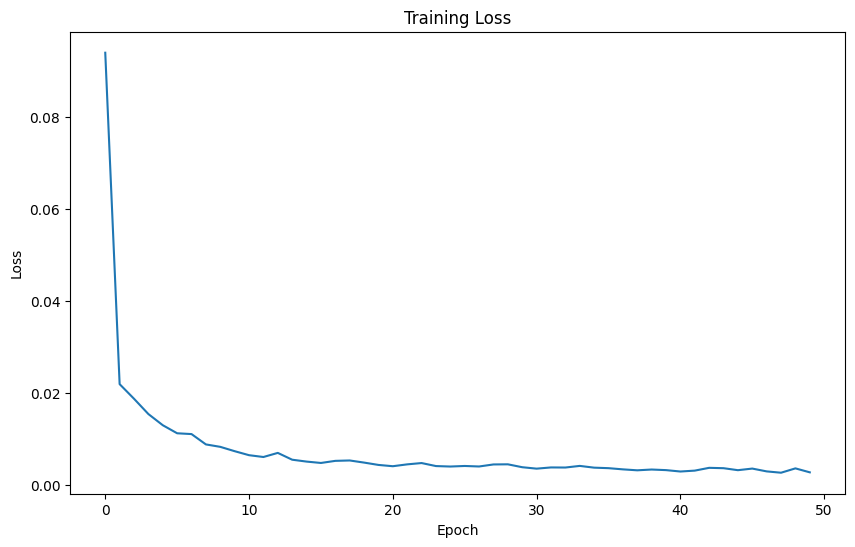

In [17]:
# Training
print("Starting training...")
train_model()

In [ ]:
print("\nGenerating sample video...")
sample_prompts = [
    #"A cat playing with a ball",
    #"A sunset over the ocean",
    #"A person walking in the park"
    "you want to begin planning in detail. This is known as the project management plan.",
    "10 to the fourth and each makes around 10 requests a day, just multiply to get five times 10 to the fifth request per"
]

for i, prompt in enumerate(sample_prompts):
    print(f"Generating video for: {prompt}")
    #video = generate_video_from_text(prompt, Config.MODEL_SAVE_PATH)
    video = generate_video_from_text(prompt, "/content/drive/MyDrive/text_to_video/text_to_video_model_weight.pth")

    # Save as GIF
    output_path = os.path.join(Config.OUTPUT_DIR, f"generated_video_{i}.gif")
    save_video_as_gif(video, output_path)
    print(f"Video saved to {output_path}")



Generating sample video...
Generating video for: you want to begin planning in detail. This is known as the project management plan.


Generating video: 100%|██████████| 1000/1000 [00:05<00:00, 198.44it/s]


Video saved to /content/drive/MyDrive/text_to_video/generated_video_0.gif
Generating video for: 10 to the fourth and each makes around 10 requests a day, just multiply to get five times 10 to the fifth request per


Generating video: 100%|██████████| 1000/1000 [00:05<00:00, 197.73it/s]


Video saved to /content/drive/MyDrive/text_to_video/generated_video_1.gif


In [19]:
sample_prompts = [
    #"A cat playing with a ball",
    #"A sunset over the ocean",
    #"A person walking in the park"
    "you want to begin planning in detail. This is known as the project management plan.",
    "10 to the fourth and each makes around 10 requests a day, just multiply to get five times 10 to the fifth request per"
]

for i, prompt in enumerate(sample_prompts):
    print(f"Generating video for: {prompt}")

        # Generate video
    video = generate_video_from_text(prompt, Config.MODEL_SAVE_PATH, high_res=False)

        # Generate audio
    audio = generate_audio_from_text(prompt, duration=len(video) / 8)  # 8 fps

        # Enhance video quality
    enhanced_video = enhance_video_quality(video)

        # Save as MP4 with audio
    output_path = os.path.join(Config.OUTPUT_DIR, f"generated_video_{i}.mp4")
    save_video_as_mp4(enhanced_video, output_path, fps=8, audio=audio)
    print(f"High-quality video with audio saved to {output_path}")

        # Also save a version without audio for comparison
    output_path_no_audio = os.path.join(Config.OUTPUT_DIR, f"generated_video_{i}_no_audio.mp4")
    save_video_as_mp4(enhanced_video, output_path_no_audio, fps=8)
    print(f"Video without audio saved to {output_path_no_audio}")


Generating video for: you want to begin planning in detail. This is known as the project management plan.


Generating video: 100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s]


High-quality video with audio saved to /content/drive/MyDrive/text_to_video_latest/generated_video_0.mp4
Video without audio saved to /content/drive/MyDrive/text_to_video_latest/generated_video_0_no_audio.mp4
Generating video for: 10 to the fourth and each makes around 10 requests a day, just multiply to get five times 10 to the fifth request per


Generating video: 100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s]


High-quality video with audio saved to /content/drive/MyDrive/text_to_video_latest/generated_video_1.mp4
Video without audio saved to /content/drive/MyDrive/text_to_video_latest/generated_video_1_no_audio.mp4
